# 計算機実習 問題12.4 継続型ランダムウォーク

## シミュレーションの目的

このシミュレーションでは、継続型ランダムウォーク、すなわち一つ前の遷移の履歴が遷移の方向を確率的に定めるような場合のランダムウォークを考える。このモデルの物理的な対応としては、後の問題で言及されているように、クロマトグラフィー柱の拡散の問題などが挙げられる。

## 実習課題

### 問題 a：

"継続型"ランダムウォークでは、遷移、すなわち"ジャンプ"の確率が直前の履歴に依存する。1次元格子上のランダムウォークを考え、すでに$N-1$ステップ進んでいるとする。$N$ステップ目は確率$\alpha$で同じ方向に進み、確率$1-\alpha$で反対方向に進む。この1次元の継続型ランダムウォークのモンテカルロ・シミュレーションを行うプログラムを書け。そして、$\langle x(N)\rangle$,$\langle x^{2}(N)\rangle$,$\langle \Delta x^{2}(N)\rangle$、$P(x，N)$を計算せよ。粒子の初期位置と初期の方向を設定する必要がある。この継続型ランダムウォークで$\alpha = 1/2$の極限はどうなるか。

継続型の1次元ランダムウォークのシミュレーションを行い、$N$に対する$\langle x(N)\rangle$と$\langle x^{2}(N)\rangle$、$\langle \Delta x^{2}(N)\rangle$のグラフを示す。

In [1]:
%matplotlib inline
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from IPython.html import widgets
from IPython.html.widgets import interact, fixed
from IPython.display import display


class HistoryDependentRW():

    def __init__(self, alpha=0.75, l=(1, 1), nwalkers=1000, x0=0):
        """ Initialize the values.

        alpha    : probability that a particle moves the same direction of the before one
        l        : step length
        nwalkers : number of trials
        x0       : initial position
        """
        self.alpha = alpha
        self.l = l
        self.nwalkers = nwalkers
        self.x0 = x0

    def random_walk_d1(self, N):
        """ Caluculate the displacements of each walkers.

        N : A list of walk steps
        """
        x = np.zeros([self.nwalkers, max(N)], 'i')
        x_direction = np.zeros([self.nwalkers, max(N)], 'i')
        p = np.random.random([self.nwalkers, max(N) - 1])
                             # generate random number in [0,1)
        alpha = self.alpha
        l = self.l
        x0 = self.x0

        for n in xrange(self.nwalkers):
            x[n][0] = x0
            x_direction[n][0] = +1 if n < int(self.nwalkers / 2) else -1
            for i in xrange(1, max(N)):
                if p[n][i - 1] < alpha:
                    x_direction[n][i] = x_direction[n][i - 1]
                else:
                    x_direction[n][i] = -x_direction[n][i - 1]

                if x_direction[n][i] > 0:
                    x[n][i] = x[n][i - 1] + x_direction[n][i] * l[0]
                else:
                    x[n][i] = x[n][i - 1] + x_direction[n][i] * l[1]

        self.x = x
        self.N = N

    def calc_ave(self):
        """ Caluculate the average of displacements after max(N) steps.

        You can call the results by "self.N", "self.x_ave", and "self.x_2_ave"
        """
        self.x_ave = np.sum(
            self.x, axis=0, dtype=np.float32) / self.nwalkers * 1.
        self.x_2_ave = np.sum(
            self.x ** 2, axis=0, dtype=np.float32) / self.nwalkers * 1.
        self.variance_x = self.x_2_ave - self.x_ave ** 2

    def show(self):
        """ Show the graph.
        """
        fig = plt.figure('random walk', figsize=(8, 8))

        x_ave = [self.x_ave[nvalue - 1] for nvalue in self.N]
        x_2_ave = [self.x_2_ave[nvalue - 1] for nvalue in self.N]
        variance_x = [self.variance_x[nvalue - 1] for nvalue in self.N]

        ax1 = fig.add_subplot(311)
        ax1.plot(self.N, x_ave)
        ax1.set_ylabel(r'$\langle x(N)\rangle$', fontsize=16)

        ax2 = fig.add_subplot(312)
        ax2.plot(self.N, x_2_ave)
        ax2.set_ylabel(r'$\langle x^{2}(N)\rangle$', fontsize=16)

        ax3 = fig.add_subplot(313)
        ax3.set_ylabel(r'$\langle \Delta x^{2}(N)\rangle$', fontsize=16)
        ax3.plot(self.N, variance_x)
        ax3.set_xlabel(r'$N$')

        plt.show()

    def caluculate_prob(self, _n):
        N = max(self.N)
        x = self.x
        count_box = np.zeros([N, 2 * N + 1], 'f')
        for n in xrange(N):
            for walker in xrange(self.nwalkers):
                count_box[n][N + x[walker][n]] += 1
        prob = count_box / self.nwalkers

        # --- show for n ---
        xmin = None
        for _x in xrange(2 * N + 1):
            if prob[_n][_x]:
                if xmin is None:
                    xmin = _x
                    xmax = _x
                xmin = min(_x, xmin)
                xmax = max(_x, xmax)

        xmargin = (xmax - xmin) * 0.05
        ymax = np.amax(prob[_n])
        ymargin = ymax * 0.1

        fig = plt.figure('probability')
        ax = fig.add_subplot(111)
        ax.grid()
        ax.set_xlim(xmin - xmargin, xmax + xmargin)
        ax.set_ylim(0, ymax + ymargin)
        ax.plot(xrange(-N, N + 1), prob[_n])
        ax.set_xlabel(r'$x$', fontsize=16)
        ax.set_ylabel(r'$P(x,N)$', fontsize=16)
        plt.show()



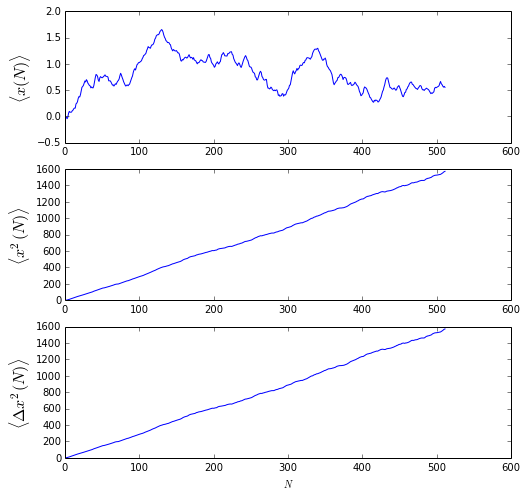

In [2]:
alpha=0.75
rw = HistoryDependentRW(alpha=alpha)
N = xrange(1, 512)
rw.random_walk_d1(N)
def ex_a_simpleplot():
    rw.calc_ave()
    rw.show()
ex_a_simpleplot()

$N=400$のときの$P(x)$

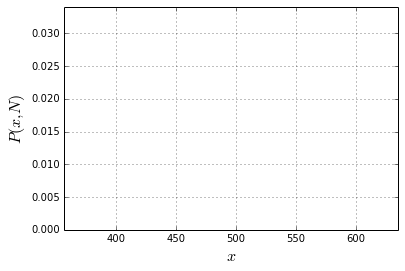

In [3]:
rw.caluculate_prob(400)

In [19]:
def fit_func(parameter0, x, y):
    a = parameter0[0]
    b = parameter0[1]
    residual = y - (a * x + b)
    return residual

parameter0 = [1.0, 1.0]  # initial values for optimize

def ex_b_nu():
    variance_x = [rw.variance_x[nvalue - 1] for nvalue in N]
    ln_N = np.log(N)
    ln_variance_x = np.log(variance_x)

    result = optimize.leastsq(fit_func, parameter0,
                              args=(ln_N, ln_variance_x))

    print 'nu =', result[0][0] / 2.

    plt.xlabel(r'$N$', fontsize=16)
    plt.ylabel(r'$\langle \Delta x^{2}(N)\rangle$', fontsize=16)
    plt.xscale('log')
    plt.yscale('log')
    plt.axis('equal')
    plt.plot(N, variance_x)
    plt.show()

ex_b_nu()

nu = 0.5


ValueError: math domain error

In [20]:
def ex_b_D():
    result = optimize.leastsq(fit_func, parameter0,
                              args=(np.arange(1, max(N)+1), rw.x_2_ave)
                              )
    print 'D =', result[0][0] / 4.
ex_b_D()

D = 0.820413293495


In [21]:
def ex_b_delta_x2(n=400):
    N = [8, 64, 256, 512]
    rw = HistoryDependentRW(alpha=alpha)
    rw.random_walk_d1(N)
    rw.calc_ave()
    for n in N:
        print '<\Delta x^{2}(%d)> = ' % n, str(rw.variance_x[n - 1])
ex_b_delta_x2()

<\Delta x^{2}(8)> =  17.5868
<\Delta x^{2}(64)> =  189.223
<\Delta x^{2}(256)> =  769.82
<\Delta x^{2}(512)> =  1545.02


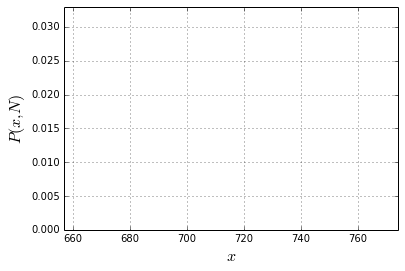

In [34]:
def ex_c():
    rw = HistoryDependentRW(alpha=0.75, l=(1, 0), nwalkers=1000)
    N = xrange(1, 512)
    rw.random_walk_d1(N)
    rw.caluculate_prob(400)
ex_c()